In [1]:
import os
import re
import math
import pickle
import random
import Orange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from humanize import ordinal
from scikit_posthocs import posthoc_nemenyi
from scipy.stats import mannwhitneyu
from scipy.spatial import ConvexHull
from skcriteria import Data, MAX
from skcriteria.madm.closeness import TOPSIS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
DATA_PATH = Path('data')
RESULTS_PATH = DATA_PATH / 'results'
META_FEATURES_PATH = DATA_PATH / 'meta_features'
OUTPUT_PATH = Path('output', 'resnet')

In [3]:
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
results_dfs = {}
for filename in os.listdir(RESULTS_PATH):
    archtecture = re.search(r'(?<=results_).*(?=.csv)', filename).group()
    results_dfs[archtecture] = pd.read_csv(RESULTS_PATH / filename)

In [5]:
results_df = pd.concat(results_dfs.values(), ignore_index=True)

In [6]:
results_df.head()

,Architecture,Task,Accuracy_vector,Precision_vector,Recall_vector,F1_vector,Accuracy_avg,Precision_avg,Recall_avg,F1_avg
0,ResNet10,airplane-automobile,"[0.942, 0.939, 0.93, 0.9275, 0.916, 0.9315, 0....","[0.9203510204081633, 0.9051657032755298, 0.893...","[0.932, 0.958, 0.948, 0.939, 0.954, 0.938, 0.8...","[0.9414141414141414, 0.9401373895976447, 0.931...",0.92505,0.892683,0.9274,0.925149
1,ResNet10,airplane-bird,"[0.89, 0.889, 0.8935, 0.882, 0.875, 0.8895, 0....","[0.8614113785557986, 0.8492249488752557, 0.852...","[0.847, 0.878, 0.89, 0.886, 0.888, 0.89, 0.887...","[0.8850574712643677, 0.8877654196157735, 0.893...",0.88480,0.843588,0.8753,0.883662
2,ResNet10,airplane-cat,"[0.9245, 0.9325, 0.935, 0.926, 0.932, 0.925, 0...","[0.8897871921182265, 0.8980344995140912, 0.905...","[0.932, 0.947, 0.937, 0.938, 0.961, 0.909, 0.8...","[0.9250620347394541, 0.933464760965993, 0.9351...",0.92580,0.893557,0.9279,0.925876
3,ResNet10,airplane-deer,"[0.9475, 0.9125, 0.943, 0.93, 0.917, 0.936, 0....","[0.9234072781655036, 0.8553790534618757, 0.921...","[0.949, 0.983, 0.933, 0.98, 0.935, 0.928, 0.95...","[0.947578632051922, 0.9182624941616068, 0.9424...",0.93320,0.900529,0.9460,0.934192
4,ResNet10,airplane-dog,"[0.948, 0.9515, 0.936, 0.947, 0.9345, 0.9475, ...","[0.924704, 0.9361238390092881, 0.9224043010752...","[0.948, 0.936, 0.901, 0.95, 0.914, 0.93, 0.955...","[0.948, 0.9507364144235654, 0.9336787564766839...",0.94470,0.923633,0.9363,0.944177


In [7]:
TASKS = results_df['Task'].unique()
ARCHITECTURES = results_df['Architecture'].unique()

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(ARCHITECTURES)

LabelEncoder()

In [9]:
leave_one_out = LeaveOneOut()

In [10]:
metrics_avg = {}
metrics_vectors = {}
for task in TASKS:
    df = results_df.query(f'Task == "{task}"')
    metrics_avg[task] = {}
    metrics_vectors[task] = {}
    for _, row in df.iterrows():
        metrics_avg[task][row['Architecture']] = {
            'accuracy': row['Accuracy_avg'],
            'precision': row['Precision_avg'],
            'recall': row['Recall_avg'],
            'f1': row['F1_avg']
        }
        metrics_vectors[task][row['Architecture']] = {
            'accuracy': np.array(eval(row['Accuracy_vector'])),
            'precision': np.array(eval(row['Precision_vector'])),
            'recall': np.array(eval(row['Recall_vector'])),
            'f1': np.array(eval(row['F1_vector']))
        }

In [11]:
ranking_architectures = {}
for task in TASKS:
    metrics_columns = ['Accuracy_avg', 'Precision_avg', 'Recall_avg', 'F1_avg']
    metrics_df = results_df.query(f'Task == "{task}"')[metrics_columns]
    data = Data(metrics_df.to_numpy(), criteria=[MAX, MAX, MAX, MAX])
    topsis = TOPSIS()
    ranking_architectures[task] = results_df.iloc[
        metrics_df.index[np.argsort(topsis.decide(data).rank_)]
    ]['Architecture'].tolist()

In [12]:
best_architectures = [
    ranking_architectures[task][0]
    for task in TASKS
]

In [13]:
y = label_encoder.transform(best_architectures)

In [14]:
def load_meta_features(feature_extractor_name: str) -> np.ndarray:
    meta_features = []
    for task in TASKS:
        filename = task + '.pkl'
        with open(META_FEATURES_PATH / feature_extractor_name / filename, 'rb') as f:
            meta_features.append(pickle.load(f))
    return np.array(meta_features)

In [15]:
handcraft_X = load_meta_features('handcraft')

In [16]:
resnet_X = load_meta_features('resnet')

In [17]:
def make_dataset_map_plot(X, y):

    def encircle(i, j, ax=None, **kw):
        if not ax:
            ax = plt.gca()
        p = np.c_[i, j]
        hull = ConvexHull(p)
        poly = plt.Polygon(p[hull.vertices, :], **kw)
        ax.add_patch(poly)

    lda = LinearDiscriminantAnalysis(n_components=2)

    component_x, component_y = lda.fit_transform(X, y).T

    g = sns.scatterplot(component_x, component_y, hue=y, style=y)
    g.legend(fontsize='x-small', frameon=False)

    for label, color in zip(np.unique(y), ('r', 'g', 'y', 'b')):
        index = np.where(label == pd.Series(y))
        encircle(
            component_x[index],
            component_y[index],
            ec=color,
            fc=color,
            alpha=0.15
        )

    plt.savefig(OUTPUT_PATH / 'datasets_map.png', dpi=1200, bbox_inches='tight')
    plt.show()

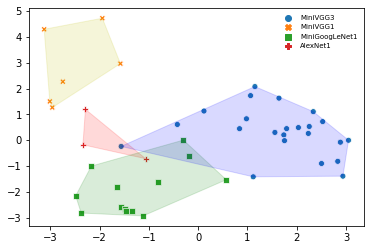

In [18]:
make_dataset_map_plot(resnet_X, best_architectures)

In [19]:
%%time

gt_recommendations = dict(zip(TASKS, best_architectures))

CPU times: user 18 µs, sys: 1 µs, total: 19 µs
Wall time: 24.3 µs


In [20]:
%%time

handcraft_rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(handcraft_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(handcraft_X[test_index])
    )[0]
    handcraft_rf_recommendations[task] = recommended_architecture

CPU times: user 8.18 s, sys: 7.56 ms, total: 8.18 s
Wall time: 8.18 s


In [21]:
%%time

resnet_rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(resnet_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(resnet_X[test_index])
    )[0]
    resnet_rf_recommendations[task] = recommended_architecture

CPU times: user 8.55 s, sys: 19.9 ms, total: 8.57 s
Wall time: 8.57 s


In [22]:
%%time

handcraft_knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(handcraft_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(handcraft_X[test_index])
    )[0]
    handcraft_knn_recommendations[task] = recommended_architecture

CPU times: user 73.7 ms, sys: 0 ns, total: 73.7 ms
Wall time: 72.2 ms


In [23]:
%%time

resnet_knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(resnet_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(resnet_X[test_index])
    )[0]
    resnet_knn_recommendations[task] = recommended_architecture

CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 70.8 ms


In [24]:
%%time

oner_recommendations = []
for _ in range(10):
    recommended_architecture = random.choice(ARCHITECTURES)
    oner_recommendations.append({
        task: recommended_architecture
        for task in TASKS
    })

CPU times: user 153 µs, sys: 0 ns, total: 153 µs
Wall time: 159 µs


In [25]:
%%time

random_recommendations = []
for _ in range(10):
    random_recommendations.append({
        task: random.choice(ARCHITECTURES)
        for task in TASKS
    })

CPU times: user 611 µs, sys: 0 ns, total: 611 µs
Wall time: 616 µs


In [26]:
def make_results(recommendations):
    results = {}
    for task in TASKS:
        best_architecture = ranking_architectures[task][0]
        worst_architecture = ranking_architectures[task][-1]
        recommended_architecture = recommendations[task]
        results[task] = {
            'Ranking_architectures': ', '.join(ranking_architectures[task]),
            'Recommendation_rank': ordinal(ranking_architectures[task].index(recommended_architecture) + 1),
            'P_value[best]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][best_architecture]['accuracy']
            )[1],
            'P_value[worst]': mannwhitneyu(
                metrics_vectors[task][recommended_architecture]['accuracy'],
                metrics_vectors[task][worst_architecture]['accuracy']
            )[1],
            'Architecture[recommended]': recommended_architecture,
            'Architecture[best]': best_architecture,
            'Architecture[worst]': worst_architecture,
            'Accuracy_avg[recommended]': metrics_avg[task][recommended_architecture]['accuracy'],
            'Accuracy_avg[best]': metrics_avg[task][best_architecture]['accuracy'],
            'Accuracy_avg[worst]': metrics_avg[task][worst_architecture]['accuracy'],
            'Precision_avg[recommended]': metrics_avg[task][recommended_architecture]['precision'],
            'Precision_avg[best]': metrics_avg[task][best_architecture]['precision'],
            'Precision_avg[worst]': metrics_avg[task][worst_architecture]['precision'],
            'Recall_avg[recommended]': metrics_avg[task][recommended_architecture]['recall'],
            'Recall_avg[best]': metrics_avg[task][best_architecture]['recall'],
            'Recall_avg[worst]': metrics_avg[task][worst_architecture]['recall'],
            'F1_avg[recommended]': metrics_avg[task][recommended_architecture]['f1'],
            'F1_avg[best]': metrics_avg[task][best_architecture]['f1'],
            'F1_avg[worst]': metrics_avg[task][worst_architecture]['f1']
        }
    return results

In [27]:
gt_results = make_results(gt_recommendations)
handcraft_rf_results = make_results(handcraft_rf_recommendations)
handcraft_knn_results = make_results(handcraft_knn_recommendations)
resnet_rf_results = make_results(resnet_rf_recommendations)
resnet_knn_results = make_results(resnet_knn_recommendations)

In [28]:
gt_results_df = pd.DataFrame(gt_results).T.rename_axis('Task').reset_index()
handcraft_rf_results_df = pd.DataFrame(handcraft_rf_results).T.rename_axis('Task').reset_index()
handcraft_knn_results_df = pd.DataFrame(handcraft_knn_results).T.rename_axis('Task').reset_index()
resnet_rf_results_df = pd.DataFrame(resnet_rf_results).T.rename_axis('Task').reset_index()
resnet_knn_results_df = pd.DataFrame(resnet_knn_results).T.rename_axis('Task').reset_index()

In [29]:
oner_results_10_executions = [
    make_results(recommendations)
    for recommendations in oner_recommendations
]

In [30]:
random_results_10_executions = [
    make_results(recommendations)
    for recommendations in random_recommendations
]

In [31]:
oner_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in oner_results_10_executions
], ignore_index=True)

In [32]:
random_results_df = pd.concat([
    pd.DataFrame(results).T.rename_axis('Task').reset_index()
    for results in random_results_10_executions
], ignore_index=True)

In [33]:
gt_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",1st,0.484868,9.13359e-05,MiniVGG1,MiniVGG1,ResNet10,0.91925,0.91925,0.8848,0.878482,0.878482,0.843588,0.9418,0.9418,0.8753,0.921148,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",1st,0.484868,9.08256e-05,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.96365,0.96365,0.91945,0.945979,0.945979,0.89732,0.9657,0.9657,0.8919,0.963716,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [34]:
gt_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    45
Name: Task, dtype: int64

In [35]:
gt_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           3
MiniGoogLeNet1    13
MiniVGG1           6
MiniVGG3          23
Name: Task, dtype: int64

In [36]:
gt_results_df.groupby('Architecture[best]').Task.count()

Architecture[best]
AlexNet1           3
MiniGoogLeNet1    13
MiniVGG1           6
MiniVGG3          23
Name: Task, dtype: int64

In [37]:
gt_results_df.groupby('Architecture[worst]').Task.count()

Architecture[worst]
AlexNet1            1
MiniVGG1            4
ResNet10            6
SmallSqueezeNet    34
Name: Task, dtype: int64

In [38]:
handcraft_rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",2nd,0.424914,8.78078e-05,MiniGoogLeNet1,MiniVGG3,ResNet10,0.96525,0.963,0.9447,0.953657,0.945098,0.923633,0.9553,0.9663,0.9363,0.96488,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484868,0.00505429,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.94775,0.94775,0.8408,0.915364,0.915364,0.816722,0.9735,0.9735,0.94,0.949271,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [39]:
handcraft_rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    21
2nd    14
3rd     5
4th     3
6th     2
Name: Task, dtype: int64

In [40]:
handcraft_rf_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
MiniGoogLeNet1    15
MiniVGG1           5
MiniVGG3          25
Name: Task, dtype: int64

In [41]:
resnet_rf_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",1st,0.484868,9.08256e-05,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.96365,0.96365,0.91945,0.945979,0.945979,0.89732,0.9657,0.9657,0.8919,0.963716,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",3rd,0.136428,0.00158141,MiniGoogLeNet1,MiniVGG3,ResNet10,0.9656,0.96305,0.95595,0.95172,0.934987,0.937775,0.961,0.9913,0.9518,0.964927,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0518597,0.000853125,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9242,0.9357,0.70285,0.896233,0.904545,0.667966,0.9136,0.9446,0.6881,0.922978,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0651403,0.0186382,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9396,0.94775,0.8408,0.919533,0.915364,0.816722,0.927,0.9735,0.94,0.938489,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",2nd,0.324704,0.000743288,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.9746,0.97695,0.90715,0.959649,0.961333,0.890751,0.9831,0.9875,0.8509,0.975034,0.977209,0.856313


In [42]:
resnet_rf_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    15
2nd    16
3rd    11
4th     2
6th     1
Name: Task, dtype: int64

In [43]:
resnet_rf_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           1
MiniGoogLeNet1     8
MiniVGG1           4
MiniVGG3          32
Name: Task, dtype: int64

In [44]:
handcraft_knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",3rd,0.298282,0.012874,MiniVGG3,MiniVGG1,ResNet10,0.9079,0.91925,0.8848,0.866139,0.878482,0.843588,0.9305,0.9418,0.8753,0.910156,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",1st,0.484822,0.00109688,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.95015,0.95015,0.9046,0.920075,0.920075,0.872486,0.9716,0.9716,0.8927,0.951379,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",1st,0.484868,0.000641022,MiniVGG3,MiniVGG3,ResNet10,0.963,0.963,0.9447,0.945098,0.945098,0.923633,0.9663,0.9663,0.9363,0.963215,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",1st,0.484868,0.0292958,MiniVGG3,MiniVGG3,ResNet10,0.96305,0.96305,0.95595,0.934987,0.934987,0.937775,0.9913,0.9913,0.9518,0.964203,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484822,9.03174e-05,MiniVGG3,MiniVGG3,ResNet10,0.965,0.965,0.9348,0.942993,0.942993,0.909471,0.9795,0.9795,0.9278,0.965587,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",1st,0.484822,0.000122402,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.9357,0.9357,0.70285,0.904545,0.904545,0.667966,0.9446,0.9446,0.6881,0.936251,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0651403,0.0186382,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9396,0.94775,0.8408,0.919533,0.915364,0.816722,0.927,0.9735,0.94,0.938489,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",1st,0.484822,0.000501778,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.97695,0.97695,0.90715,0.961333,0.961333,0.890751,0.9875,0.9875,0.8509,0.977209,0.977209,0.856313


In [45]:
handcraft_knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    16
2nd    17
3rd     7
4th     5
Name: Task, dtype: int64

In [46]:
handcraft_knn_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           1
MiniGoogLeNet1    15
MiniVGG1           1
MiniVGG3          28
Name: Task, dtype: int64

In [47]:
resnet_knn_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",4th,0.00505429,0.0347163,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.94405,0.97175,0.87925,0.93243,0.953785,0.85842,0.9128,0.9827,0.808,0.938552,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",4th,0.0319611,9.08256e-05,AlexNet1,MiniVGG1,ResNet10,0.91105,0.91925,0.8848,0.87307,0.878482,0.843588,0.9188,0.9418,0.8753,0.911862,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",5th,0.469826,0.00180526,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.93295,0.95015,0.9046,0.914124,0.920075,0.872486,0.9076,0.9716,0.8927,0.924527,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",1st,0.484868,9.08256e-05,MiniGoogLeNet1,MiniGoogLeNet1,SmallSqueezeNet,0.96365,0.96365,0.91945,0.945979,0.945979,0.89732,0.9657,0.9657,0.8919,0.963716,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
5,airplane-frog,"MiniVGG3, AlexNet1, MiniGoogLeNet1, SmallSquee...",3rd,0.136428,0.00158141,MiniGoogLeNet1,MiniVGG3,ResNet10,0.9656,0.96305,0.95595,0.95172,0.934987,0.937775,0.961,0.9913,0.9518,0.964927,0.964203,0.955717
6,airplane-horse,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",3rd,0.247821,8.98113e-05,MiniGoogLeNet1,MiniVGG3,ResNet10,0.96275,0.965,0.9348,0.946118,0.942993,0.909471,0.9622,0.9795,0.9278,0.962799,0.965587,0.934305
7,airplane-ship,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.0518597,0.000853125,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9242,0.9357,0.70285,0.896233,0.904545,0.667966,0.9136,0.9446,0.6881,0.922978,0.936251,0.669603
8,airplane-truck,"MiniVGG3, AlexNet1, MiniGoogLeNet1, MiniVGG1, ...",2nd,0.0225773,0.0480267,AlexNet1,MiniVGG3,SmallSqueezeNet,0.93805,0.94775,0.8408,0.906491,0.915364,0.816722,0.9518,0.9735,0.94,0.938933,0.949271,0.87413
9,automobile-bird,"MiniGoogLeNet1, MiniVGG3, AlexNet1, MiniVGG1, ...",2nd,0.324704,0.000743288,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.9746,0.97695,0.90715,0.959649,0.961333,0.890751,0.9831,0.9875,0.8509,0.975034,0.977209,0.856313


In [48]:
resnet_knn_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    12
2nd    12
3rd    13
4th     6
5th     1
6th     1
Name: Task, dtype: int64

In [49]:
resnet_knn_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           3
MiniGoogLeNet1    17
MiniVGG1           5
MiniVGG3          20
Name: Task, dtype: int64

In [50]:
oner_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",2nd,0.484914,0.000121743,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.9719,0.97175,0.87925,0.956602,0.953785,0.85842,0.9766,0.9827,0.808,0.972037,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",1st,0.484868,9.13359e-05,MiniVGG1,MiniVGG1,ResNet10,0.91925,0.91925,0.8848,0.878482,0.878482,0.843588,0.9418,0.9418,0.8753,0.921148,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",2nd,0.0808284,0.00405156,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.9439,0.95015,0.9046,0.910412,0.920075,0.872486,0.9694,0.9716,0.8927,0.945516,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",5th,9.13359e-05,0.0928556,MiniVGG1,MiniGoogLeNet1,SmallSqueezeNet,0.89945,0.96365,0.91945,0.836805,0.945979,0.89732,0.9932,0.9657,0.8919,0.908942,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",4th,0.0032408,0.136157,MiniVGG1,MiniVGG3,ResNet10,0.9483,0.963,0.9447,0.9141,0.945098,0.923633,0.9797,0.9663,0.9363,0.950101,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",1st,0.484776,0.00138271,MiniGoogLeNet1,MiniGoogLeNet1,AlexNet1,0.9813,0.9813,0.97055,0.974671,0.974671,0.96372,0.9763,0.9763,0.9552,0.981136,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",3rd,0.112888,0.00179264,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.9731,0.9801,0.93615,0.969426,0.976707,0.921241,0.9537,0.9671,0.914,0.971268,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",4th,0.22459,0.00109688,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.96425,0.97825,0.92565,0.947815,0.970667,0.896233,0.9823,0.9724,0.9546,0.967171,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",3rd,0.0800373,0.00156438,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.96465,0.97565,0.88885,0.952876,0.963455,0.866129,0.9543,0.978,0.9128,0.963514,0.975767,0.897996


In [51]:
oner_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st     99
2nd    100
3rd    111
4th    100
5th     26
6th     14
Name: Task, dtype: int64

In [52]:
oner_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st     9.9
2nd    10.0
3rd    11.1
4th    10.0
5th     2.6
6th     1.4
Name: Task, dtype: float64

In [53]:
oner_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           90
MiniGoogLeNet1    180
MiniVGG1          135
MiniVGG3           45
Name: Task, dtype: int64

In [54]:
oner_results_df.groupby('Architecture[recommended]').Task.count() / 10

Architecture[recommended]
AlexNet1           9.0
MiniGoogLeNet1    18.0
MiniVGG1          13.5
MiniVGG3           4.5
Name: Task, dtype: float64

In [55]:
random_results_df

,Task,Ranking_architectures,Recommendation_rank,P_value[best],P_value[worst],Architecture[recommended],Architecture[best],Architecture[worst],Accuracy_avg[recommended],Accuracy_avg[best],Accuracy_avg[worst],Precision_avg[recommended],Precision_avg[best],Precision_avg[worst],Recall_avg[recommended],Recall_avg[best],Recall_avg[worst],F1_avg[recommended],F1_avg[best],F1_avg[worst]
0,airplane-automobile,"MiniVGG3, MiniVGG1, AlexNet1, MiniGoogLeNet1, ...",1st,0.484868,0.000503988,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97175,0.97175,0.87925,0.953785,0.953785,0.85842,0.9827,0.9827,0.808,0.97206,0.97206,0.824166
1,airplane-bird,"MiniVGG1, MiniGoogLeNet1, MiniVGG3, AlexNet1, ...",6th,9.13359e-05,0.484868,ResNet10,MiniVGG1,ResNet10,0.8848,0.91925,0.8848,0.843588,0.878482,0.843588,0.8753,0.9418,0.8753,0.883662,0.921148,0.883662
2,airplane-cat,"MiniVGG3, MiniVGG1, AlexNet1, ResNet10, MiniGo...",2nd,0.0808284,0.00405156,MiniVGG1,MiniVGG3,SmallSqueezeNet,0.9439,0.95015,0.9046,0.910412,0.920075,0.872486,0.9694,0.9716,0.8927,0.945516,0.951379,0.900057
3,airplane-deer,"MiniGoogLeNet1, MiniVGG3, AlexNet1, ResNet10, ...",2nd,0.0376108,0.0141233,MiniVGG3,MiniGoogLeNet1,SmallSqueezeNet,0.95065,0.96365,0.91945,0.918533,0.945979,0.89732,0.9789,0.9657,0.8919,0.952252,0.963716,0.91518
4,airplane-dog,"MiniVGG3, MiniGoogLeNet1, AlexNet1, MiniVGG1, ...",3rd,0.0319611,0.000317934,AlexNet1,MiniVGG3,ResNet10,0.9581,0.963,0.9447,0.940157,0.945098,0.923633,0.9558,0.9663,0.9363,0.957924,0.963215,0.944177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,frog-ship,"MiniGoogLeNet1, MiniVGG3, MiniVGG1, SmallSquee...",4th,0.000842869,0.410132,SmallSqueezeNet,MiniGoogLeNet1,AlexNet1,0.97125,0.9813,0.97055,0.957307,0.974671,0.96372,0.9728,0.9763,0.9552,0.971265,0.981136,0.969897
446,frog-truck,"MiniVGG3, ResNet10, MiniGoogLeNet1, MiniVGG1, ...",2nd,0.010446,0.0140343,ResNet10,MiniVGG3,SmallSqueezeNet,0.9751,0.9801,0.93615,0.963367,0.976707,0.921241,0.9753,0.9671,0.914,0.975139,0.979792,0.934866
447,horse-ship,"MiniVGG3, AlexNet1, MiniVGG1, MiniGoogLeNet1, ...",4th,0.22459,0.00109688,MiniGoogLeNet1,MiniVGG3,SmallSqueezeNet,0.96425,0.97825,0.92565,0.947815,0.970667,0.896233,0.9823,0.9724,0.9546,0.967171,0.97812,0.930716
448,horse-truck,"MiniVGG3, MiniVGG1, MiniGoogLeNet1, AlexNet1, ...",1st,0.484776,0.000740226,MiniVGG3,MiniVGG3,SmallSqueezeNet,0.97565,0.97565,0.88885,0.963455,0.963455,0.866129,0.978,0.978,0.9128,0.975767,0.975767,0.897996


In [56]:
random_results_df.groupby('Recommendation_rank').Task.count()

Recommendation_rank
1st    64
2nd    74
3rd    83
4th    68
5th    72
6th    89
Name: Task, dtype: int64

In [57]:
random_results_df.groupby('Recommendation_rank').Task.count() / 10

Recommendation_rank
1st    6.4
2nd    7.4
3rd    8.3
4th    6.8
5th    7.2
6th    8.9
Name: Task, dtype: float64

In [58]:
random_results_df.groupby('Architecture[recommended]').Task.count()

Architecture[recommended]
AlexNet1           71
MiniGoogLeNet1     75
MiniVGG1           53
MiniVGG3           79
ResNet10           83
SmallSqueezeNet    89
Name: Task, dtype: int64

In [59]:
random_results_df.groupby('Architecture[recommended]').Task.count() / 10

Architecture[recommended]
AlexNet1           7.1
MiniGoogLeNet1     7.5
MiniVGG1           5.3
MiniVGG3           7.9
ResNet10           8.3
SmallSqueezeNet    8.9
Name: Task, dtype: float64

In [60]:
algorithms_recommendations_dfs = {
    'GT': gt_results_df,
    'handcraft_RF': handcraft_rf_results_df,
    'resnet_RF': resnet_rf_results_df,
    'handcraft_KNN': handcraft_knn_results_df,
    'resnet_KNN': resnet_knn_results_df,
    'OneR': oner_results_df,
    'Random': random_results_df
}

In [61]:
metrics_dfs = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    metrics_dfs[algorithm] = recommendations_df.groupby('Task').apply(np.mean).reset_index()

In [62]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_mean': np.mean(metrics_df['Accuracy_avg[recommended]']),
        'Accuracy_std': np.std(metrics_df['Accuracy_avg[recommended]']),
        'Precision_mean': np.mean(metrics_df['Precision_avg[recommended]']),
        'Precision_std': np.std(metrics_df['Precision_avg[recommended]']),
        'Recall_mean': np.mean(metrics_df['Recall_avg[recommended]']),
        'Recall_std': np.std(metrics_df['Recall_avg[recommended]']),
        'F1_mean': np.mean(metrics_df['F1_avg[recommended]']),
        'F1_std': np.std(metrics_df['F1_avg[recommended]'])
    }
pd.DataFrame(data).T

,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_mean,F1_std
GT,0.946940,0.037275,0.923003,0.051634,0.954076,0.038517,0.947482,0.037054
handcraft_RF,0.938960,0.044599,0.915163,0.053977,0.937798,0.073783,0.937529,0.050374
resnet_RF,0.938690,0.048561,0.915543,0.059257,0.936413,0.073003,0.937206,0.054404
handcraft_KNN,0.941791,0.036199,0.917814,0.048808,0.944056,0.042035,0.941651,0.036437
resnet_KNN,0.937214,0.047928,0.914953,0.058293,0.930729,0.072214,0.935143,0.053862
OneR,0.933586,0.044099,0.907793,0.057474,0.936209,0.052513,0.933178,0.045401
Random,0.918469,0.053564,0.890225,0.064913,0.923132,0.051762,0.917627,0.053101


In [63]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(10 if algorithm in {'Random', 'OneR'} else 1)
pd.DataFrame(data).fillna(0)

,GT,handcraft_RF,resnet_RF,handcraft_KNN,resnet_KNN,OneR,Random
1st,45.0,21.0,15.0,16.0,12.0,9.9,6.4
2nd,0.0,14.0,16.0,17.0,12.0,10.0,7.4
3rd,0.0,5.0,11.0,7.0,13.0,11.1,8.3
4th,0.0,3.0,2.0,5.0,6.0,10.0,6.8
5th,0.0,0.0,0.0,0.0,1.0,2.6,7.2
6th,0.0,2.0,1.0,0.0,1.0,1.4,8.9


In [64]:
data = {}
for algorithm, recommendations_df in algorithms_recommendations_dfs.items():
    data[algorithm] = recommendations_df.groupby(
        'Recommendation_rank'
    ).Task.count().divide(len(recommendations_df))
pd.DataFrame(data).fillna(0)

,GT,handcraft_RF,resnet_RF,handcraft_KNN,resnet_KNN,OneR,Random
1st,1.0,0.466667,0.333333,0.355556,0.266667,0.220000,0.142222
2nd,0.0,0.311111,0.355556,0.377778,0.266667,0.222222,0.164444
3rd,0.0,0.111111,0.244444,0.155556,0.288889,0.246667,0.184444
4th,0.0,0.066667,0.044444,0.111111,0.133333,0.222222,0.151111
5th,0.0,0.000000,0.000000,0.000000,0.022222,0.057778,0.160000
6th,0.0,0.044444,0.022222,0.000000,0.022222,0.031111,0.197778


In [65]:
data = {}
for algorithm, metrics_df in metrics_dfs.items():
    data[algorithm] = {
        'Accuracy_p_value': mannwhitneyu(
            metrics_df['Accuracy_avg[recommended]'],
            metrics_df['Accuracy_avg[best]']
        )[1],
        'Precision_p_value': mannwhitneyu(
            metrics_df['Precision_avg[recommended]'],
            metrics_df['Precision_avg[best]']
        )[1],
        'Recall_p_value': mannwhitneyu(
            metrics_df['Recall_avg[recommended]'],
            metrics_df['Recall_avg[best]']
        )[1],
        'F1_p_value': mannwhitneyu(
            metrics_df['F1_avg[recommended]'],
            metrics_df['F1_avg[best]']
        )[1]
    }
pd.DataFrame(data)

,GT,handcraft_RF,resnet_RF,handcraft_KNN,resnet_KNN,OneR,Random
Accuracy_p_value,0.49839,0.145203,0.191716,0.113811,0.118548,0.025900,0.000350
Precision_p_value,0.49839,0.173557,0.263200,0.180901,0.226471,0.056863,0.001238
Recall_p_value,0.49839,0.225246,0.146130,0.083790,0.022243,0.015915,0.000079
F1_p_value,0.49839,0.135316,0.186262,0.098311,0.102577,0.024943,0.000268


In [66]:
def make_cd(metric):
    algorithms = list(metrics_dfs.keys())
    data = [
        metrics_dfs[algorithm][metric].tolist()
        for algorithm in algorithms
    ]
    result_df = posthoc_nemenyi(data)
    result_df.index, result_df.columns = algorithms, algorithms
    names = algorithms
    avranks = (1 - np.abs(result_df['GT'])) * 5 + 1
    cd = Orange.evaluation.compute_CD(avranks, 45)
    print('cd:', cd)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd)
    plt.savefig(OUTPUT_PATH / f'cd_{metric}.png', dpi=1200, bbox_inches='tight')
    plt.show()

cd: 1.3427239947686223


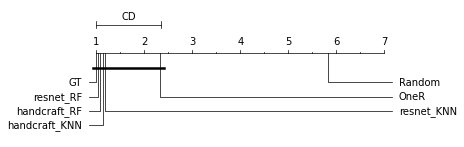

In [67]:
make_cd('Accuracy_avg[recommended]')

cd: 1.3427239947686223


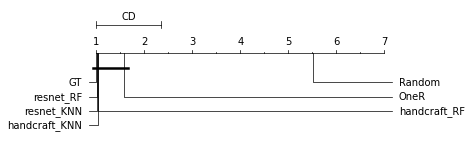

In [68]:
make_cd('Precision_avg[recommended]')

cd: 1.3427239947686223


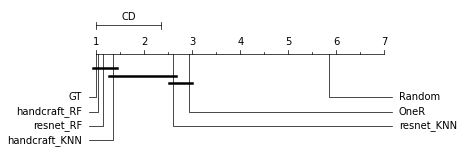

In [69]:
make_cd('Recall_avg[recommended]')

cd: 1.3427239947686223


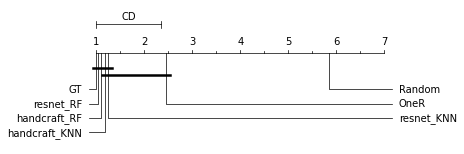

In [70]:
make_cd('F1_avg[recommended]')

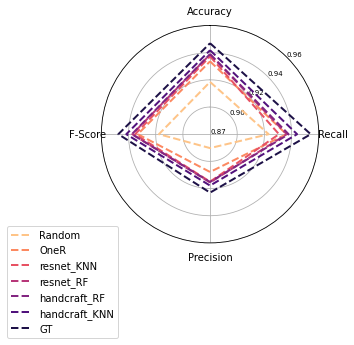

In [71]:
data = {
    'Algorithm': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F-Score': []
}

for algorithm, metrics_df in metrics_dfs.items():
    data['Algorithm'].append(algorithm)
    data['Recall'].append(np.mean(metrics_df['Recall_avg[recommended]']))
    data['Accuracy'].append(np.mean(metrics_df['Accuracy_avg[recommended]']))
    data['F-Score'].append(np.mean(metrics_df['F1_avg[recommended]']))
    data['Precision'].append(np.mean(metrics_df['Precision_avg[recommended]']))

df = pd.DataFrame(data).sort_values(by='Accuracy').reset_index(drop=True)

# ------- PART 1: Create background

# number of variable
categories = list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(math.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(45)
plt.yticks([0.88, 0.9, 0.92, 0.94, 0.96], ["0.87", "0.90", "0.92", "0.94", "0.96"], color="black", size=7)
plt.ylim(0.88, 0.96)

# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

colors = sns.color_palette('magma', len(df))

for i in range(len(df)):
    algorithm = df.loc[i]['Algorithm']
    values = df.loc[i].drop('Algorithm').values.flatten().tolist()
    values += values[:1]
    ax.plot(
        angles,
        values,
        linewidth=2,
        linestyle='dashed',
        label=algorithm,
        color=colors.pop()
    )

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig(OUTPUT_PATH / 'radar.png', dpi=1200, bbox_inches='tight')
plt.show()